# Final project

The first few cells are not supposed to be ran. These cells are how I preprosessed the data locally


In [ ]:
import os
import librosa
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
import shutil
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

## Do not run the cells inbetween these lines

# -----------------------------------------

In [ ]:
root_path = '/Users/markusfreyr/Desktop/School-stuff/MIR/Finalproj/open-unmix-pytorch'


In [ ]:
# Here I go over all files in Emotional voices dataset and discard files that a less than 5 seconds
# And rest of the files I trim them to be 5 seconds.
for root, dirs, files in os.walk("EmoV-DB_sorted"):
    for file in files:
        if file.endswith('.wav'):
            file_name = os.path.join(root,file)
            dur = librosa.get_duration(filename=file_name)
            if dur < 5.0:
                os.remove(file_name)
            trim_wav(file_name,os.path.join('EmoV-DB_sorted_trimmed',file) ,0,5 )
            

In [ ]:
#Train test split data for spoken words
train_path = os.path.join(root_path, 'data', 'train', 'speaking')
test_path = os.path.join(root_path, 'data', 'test', 'speaking')
spk_data = os.listdir(os.path.join(root_path,'EmoV-DB_sorted_trimmed',))
train_spk, test_spk = train_test_split(spk_data, test_size=0.2, random_state=42)


for split, fns in zip(['train', 'valid'], [train_spk,test_spk]):
    for fn in fns:
        shutil.copyfile(os.path.join(root_path,'EmoV-DB_sorted_trimmed',fn), os.path.join(root_path,'data',split,'speaking',fn))
    
    

In [ ]:
#Train test split data for interference
df = pd.read_csv(os.path.join(root_path,'ESC-50-master', 'meta', 'esc50.csv'))

inter_dirs = np.unique(df.category).tolist()

for cat in inter_dirs:
    df_cat = df[df.category == cat]
    train_df, test_df = train_test_split(df_cat, test_size=0.1, random_state=42)
    for split, split_df in zip(['train', 'valid'],[train_df, test_df]):
        for i, row in split_df.iterrows():
            fn = row['filename']
            shutil.copyfile(os.path.join(root_path,'ESC-50-master','audio',fn), os.path.join(root_path,'data',split,'interfer',fn))
            



In [ ]:
#helper function for trimming data
def trim_wav( originalWavPath, newWavPath , start, end ):
    '''
    :param originalWavPath: the path to the source wav file
    :param newWavPath: output wav file * can be same path as original
    :param start: time in seconds
    :param end: time in seconds
    :return:
    '''
    #sampleRate, waveData = wavfile.read( originalWavPath )
    waveData, sampleRate  = librosa.load(originalWavPath, sr=44100)
    startSample = int( start * sampleRate )
    endSample = int( end * sampleRate )
    wavfile.write( newWavPath, sampleRate, waveData[startSample:endSample])
 

 # ---------------------------------------------
       
        

In [ ]:
path = 'open-unmix-512/speaking.json'

In [ ]:
#fetching the json file for loss data
with open(path) as handle:
    data = json.load(handle)

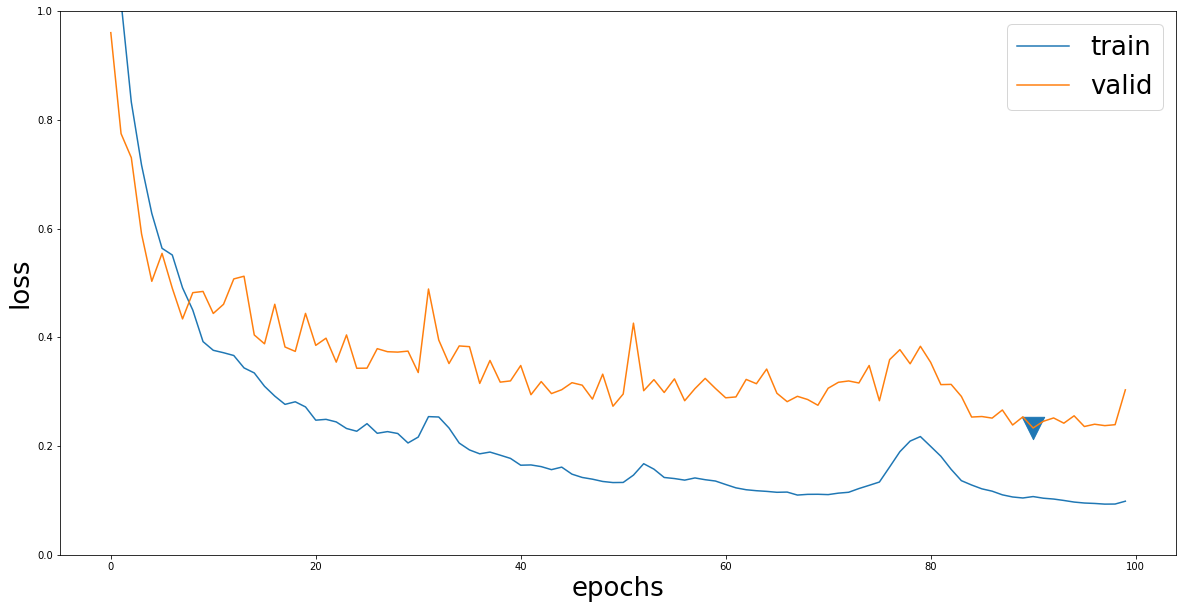

In [ ]:
#plotting the loss data
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data['train_loss_history'], label='train')
ax.plot(data['valid_loss_history'], label='valid')
ax.scatter(data['best_epoch']-1, data['best_loss'], s=500, marker='v')#plot the best epoch
plt.legend(prop={'size':26})
plt.ylim([0.0,1.0])
ax.set_xlabel('epochs',size=26)
ax.set_ylabel('loss',size=26)
plt.show()

In [ ]:
from openunmix import predict
from openunmix import utils
from openunmix import evaluate
import torch
import mir_eval
from IPython.display import Audio 


In [ ]:
#paths to audio data. I only took 5 samples of each because I thought
#it would be unnecessary to have all the audio data and it is quite a lot
path_inter = 'data/train/interfer'
path_vocal = 'data/train/speaking'

In [ ]:
#make paths for each file in a list
inters = ['1-5996-A-6.wav',
'1-137-A-32.wav',
'1-977-A-39.wav',
'1-1791-A-26.wav',
'1-4211-A-12.wav']
inters = [os.path.join(path_inter, x) for x in inters]

vocals = ['amused_1-15_0003.wav',
'amused_1-15_0010.wav',
'amused_1-15_0011.wav',
'amused_1-28_0001.wav',
'amused_1-28_0003.wav']

vocals = [os.path.join(path_vocal, x) for x in vocals]

In [ ]:
# I take two signals and mix them together and then apply separation prediction on the mix.
# I calculate the evalutation for each separation
SDR_results = []
for i in range(5):
    rate_i, wav_i = wavfile.read(inters[i])
    rate_v, wav_v = wavfile.read(vocals[i])
    mix = wav_i + wav_v
    mix = np.expand_dims(mix, axis=1)
    mix_tensor = utils.preprocess(torch.tensor(mix), rate_v,rate_v)
    estimates = predict.separate(audio=mix_tensor, rate=rate_v, targets=['speaking'], 
                             residual=True, model_str_or_path='open-unmix-512')
    SDR, SIR, SAR, perm = mir_eval.separation.bss_eval_sources(wav_v, np.array(estimates['speaking'].squeeze())[0])
    SDR_results.append(SDR)

In [ ]:
SDR_results

[array([-37.95344581]),
 array([-25.21580209]),
 array([-39.463604]),
 array([-42.94104204]),
 array([-35.01951836])]

In [ ]:
# The next couple cells are an example of the model
# you can listen to each sound file before and after separation.

rate_v, wav_v = wavfile.read(vocals[0])
print('Speaking')
display(Audio(wav_v,rate=rate_v))


rate_i, wav_i = wavfile.read(inters[0])

print('interfering sound')
display(Audio(wav_i,rate=rate_i))

Speaking


interfering sound


In [ ]:
mix = wav_i + wav_v

mix_e = np.expand_dims(mix, axis=1)

mix_t = utils.preprocess(torch.tensor(mix_e), rate_v,rate_v)


In [ ]:
estimates = predict.separate(audio=mix_t, rate=rate_v, targets=['speaking'], 
                             residual=True, model_str_or_path='open-unmix-512')

In [ ]:
for target, estimate in estimates.items():
    print(target)
    display(Audio(estimate.squeeze(), rate=rate_v))

speaking


residual
